### Visualizing Linear Regression

In [94]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np

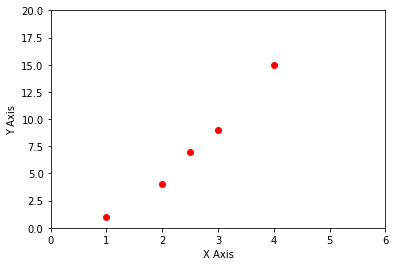

In [95]:
# creating a small dataset and visualizing
x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
plt.plot(x, y, 'ro')
plt.axis([0,6,0,20])
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.show()

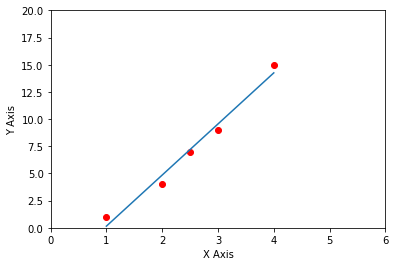

In [96]:
# fitting a line through the dataset
plt.plot(x, y, 'ro')
plt.axis([0,6,0,20])
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x,y,1))(np.unique(x)))
plt.show()

### Setup and Imports

In [97]:
! pip install -q sklearn

In [98]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [99]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

## Data

### Loading Dataset

In [100]:
df_titanic_train = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
df_titanic_test = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")

y_train = df_titanic_train.pop('survived')
y_test = df_titanic_test.pop('survived')

### Explore the Data

In [101]:
# Explore first few lines of the dataframe
df_titanic_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [102]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [103]:
# statistical analysis
df_titanic_train.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [104]:
# shape of dataframe
df_titanic_train.shape

(627, 9)

### Visualize Data

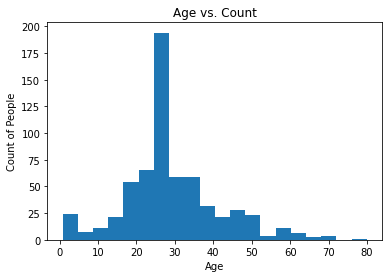

In [105]:
# visualising the age
plt.hist(df_titanic_train["age"], bins = 20)
plt.xlabel("Age")
plt.ylabel("Count of People")
plt.title("Age vs. Count")
plt.show()


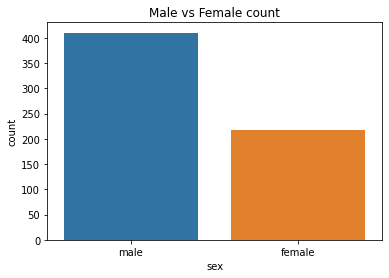

In [106]:
# visualising the sex
sns.countplot(x = df_titanic_train["sex"])
plt.title("Male vs Female count")
plt.show()

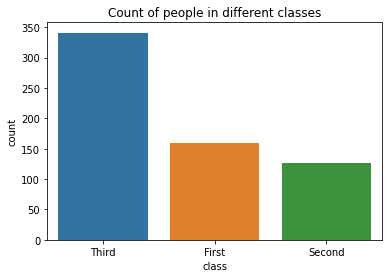

In [107]:
# visualising the class
sns.countplot(x = df_titanic_train["class"])
plt.title("Count of people in different classes")
plt.show()

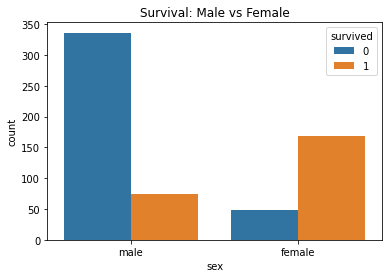

In [108]:
# Survival male vs female
temp_df = pd.concat([df_titanic_train, y_train], axis = 1)
sns.countplot(x = "sex", hue = "survived", data = temp_df)
plt.title("Survival: Male vs Female")
plt.show()

### Analysis

*   Majority people lie between 20's and 30's
*   Count of male passengers is high as compared to female.
*   Majority of people are in the third class
*   There are much more female survivors as compared to male.



### Preprocessing

In [109]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', \
                       'embark_town', 'alone']

NUMERICAL_COLUMNS = ['age', 'fare']

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = df_titanic_train[feature_name].unique() # gets all unique values from a feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERICAL_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype = tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

### Input Function

In [110]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle = True, batch_size = 32):
  def input_fn(): # inner function that will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) # create tf.data.Dataset object
    if shuffle:
      ds = ds.shuffle(1000) # randomize the order
    ds = ds.batch(batch_size).repeat(num_epochs) #split dataset for batches of 32 and repeat process for number of epochs
    return ds # return a batch of the dataset
  return input_fn # return a function object for use

## Creating the model

### Creating input function for train and test data

In [111]:
train_input_fn = make_input_fn(df_titanic_train, y_train)
test_input_fn = make_input_fn(df_titanic_test, y_test, num_epochs=1, shuffle=False)

### Creating Estimator

In [112]:
# creating the estimator
linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns)

### Model Training

In [113]:
# model training
linear_est.train(train_input_fn)

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


### Making Predictions

In [114]:
# making predictions for test data
result = linear_est.evaluate(test_input_fn)

In [115]:
print(result['accuracy'])

0.7651515


In [121]:
result = list(linear_est.predict(test_input_fn))
print(df_titanic_test.loc[2])
print(y_test.loc[2])
print(result[2]['probabilities'][1])

sex                        female
age                          58.0
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           Southampton
alone                           y
Name: 2, dtype: object
1
0.5569867
